In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.metrics import confusion_matrix

In [3]:
test_df = pd.read_csv('test.csv')

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df.shape

(42000, 785)

In [7]:
test_df.shape

(28000, 784)

In [8]:
# Drop 'label' column
X_train = train_df.drop(labels = ["label"],axis = 1) 

In [9]:
# only label column
Y_train = train_df["label"]

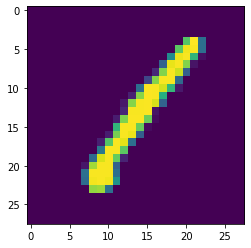

In [10]:
X_train = X_train.values.reshape(-1,28,28,1)
g = plt.imshow(X_train[0][:,:,0])

## Preprocessing Data

In [11]:
Y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64


Our labels are literally categories of numbers. We need to translate this to be "one hot encoded" so our CNN can understand, otherwise it will think this is some sort of regression problem on a continuous axis. Keras has an easy to use function for this:

In [12]:
from tensorflow.keras.utils import to_categorical

In [14]:

Y_train_cat = to_categorical(Y_train)

In [15]:
Y_train_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)